This notebook reads in the PHANGS_SNe catalog file ('1.PHANGS_SNe.csv') andplots the objects that have gone off in the larger PHANGS footprint. 


In [1]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import ascii
import os
from os import path

import warnings
warnings.filterwarnings("ignore")

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [2]:
# Import SN data
Cat = '../Data/1.PHANGS_SNe.csv'
SNTable = Table.read(Cat, format='csv')
galaxies = SNTable['Galaxy']
year=SNTable["Discovery Date"]
year = [x[0:4] for x in year]

# Construct FileName List

prefix = "/data/tycho/0/leroy.42/projects/sfsynthesis/working_data/target_headers/"
suffix = "_template2d_native.fits"
fileNames = [prefix + x + suffix for x in galaxies]

# for i in range(len(fileNames)):   #If no 3d file, use 2d
#     if path.isfile(fileNames[i]) == False:
# fileNames[i] = fileNames[i].replace('3d', '2d')

#brainstorming how to deal with duplicate SN, leaving it for now
# for i in range(len(SNTable)):
#     if (SNTable["SNe Name"][i]=="SN1986E" and SNTable["Galaxy"][i]=="ngc4298"):
#         SNTable[i].remove_row()
#     elif (SNTable["SNe Name"][i]=="SN1986E" and SNTable["Galaxy"][i]=="ngc4303"):
#         SNTable["Galaxy"]

# Construct DSS FileName List NEED TO GET CORRECT ASTROMETRY ON THESE FIRST

# prefix = "/data/tycho/0/leroy.42/projects/sfsynthesis/working_data/iroptuv/dss/native/"
# suffix = "_dss_native.fits"
# fileNames = [prefix + x + suffix for x in galaxies]


In [3]:
#CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(galaxy,SNras, SNdecs, SNnames, SNtypes, GalaxyImg, years):
    hdulist = pyfits.open(GalaxyImg)
    map = hdulist[0].data
    wcs = WCS(hdulist[0].header, naxis=2)
    
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[0].header['NAXIS1']
    naxis2 = hdulist[0].header['NAXIS2']

    is_in_x = (pix_x >= 0) & (pix_x <= naxis[0]-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis[1]-1)
             
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]
    year_in_image = np.array(years)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    
#     if (name_in_image = [])
#         return("No SNe")
#     else:
    return (galaxy,name_in_image, type_in_image, ra_in_image, dec_in_image, year_in_image,x_coord, y_coord, map)


In [4]:
#remove duplicate filenames
files, gals_unique,dssfiles = [],[],[]
[files.append(x) for x in fileNames if x not in files]
# [dssfiles.append(x) for x in dssFileNames if x not in dssfiles]
[gals_unique.append(x) for x in galaxies if x not in gals_unique]

print(files[0])


/data/tycho/0/leroy.42/projects/sfsynthesis/working_data/target_headers/eso097-013_template2d_native.fits


In [5]:
from reproject import reproject_interp

# set up plotting information
plots, wcss, hdus, names, types, ras, decs, yr, xs, ys,gals = [],[],[],[],[],[],[],[],[],[],[]
# scalebars, cutoutsbs =[],[]

for i in range(len(files)):
    if os.path.isfile(files[i]):
        gs, ns, ts, rs, ds, yrs, xcs, ycs, ms = check_in_image(gals_unique[i],SNTable["SNe Ra"], SNTable["SNe Dec"], 
                                                           SNTable["SNe Name"], SNTable["SNe Type"], 
                                                           files[i], year)
        if gs != []:
            gals.append(gs)
            names.append(ns)
            types.append(ts)
            ras.append(rs)
            decs.append(ds)
            yr.append(yrs)
            xs.append(xcs)
            ys.append(ycs)
            plots.append(ms)

            fpt_hdu = pyfits.open(files[i])
#             img_hdu = pyfits.open(dssfiles[i])
#             img_arr, img_ftp = reproject_interp(img_hdu, fpt_hdu[0].header)

            hdus.append(fpt_hdu)        
            wcss.append(WCS(fpt_hdu[0].header, naxis=2))

#             hdus.append(img_hdu)        
#             wcss.append(WCS(img_hdu[0].header, naxis=2))



# print(types)


In [6]:
# set up legend labels
print(len(names[0]))

legendLabels = []

for i in range(len(names)):
    legendlabel = []
    if len(names[i]) != 0:
        if len(names[i]) > 1:
            for k in range(len(names[i])):
                legendlabel.append(names[i][k] + ' '  + types[i][k])
        else:        
            legendlabel.append(names[i][0] + " "  + types[i][0])
        
    legendLabels.append(legendlabel)

# legendLabels

1


In [7]:
# set up plot specifics
from matplotlib.patches import Circle

markerShapes = ["o", "s", "p", "D", "X", "H", "v", "^", "<", ">", "1", "2", "3", "4",
               "o", "s", "p", "D", "X", "H", "v", "^", "<", ">", "1", "2", "3", "4"]
markerSizes  = [210,150,310,150,330,310,350,350,350,350,350,350,350,350,
               210,150,310,150,330,310,350,350,350,350,350,350,350,350]
markerEdges  = [410,350,610,350,630,610,650,650,650,650,650,650,650,650,
               410,350,610,350,630,610,650,650,650,650,650,650,650,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

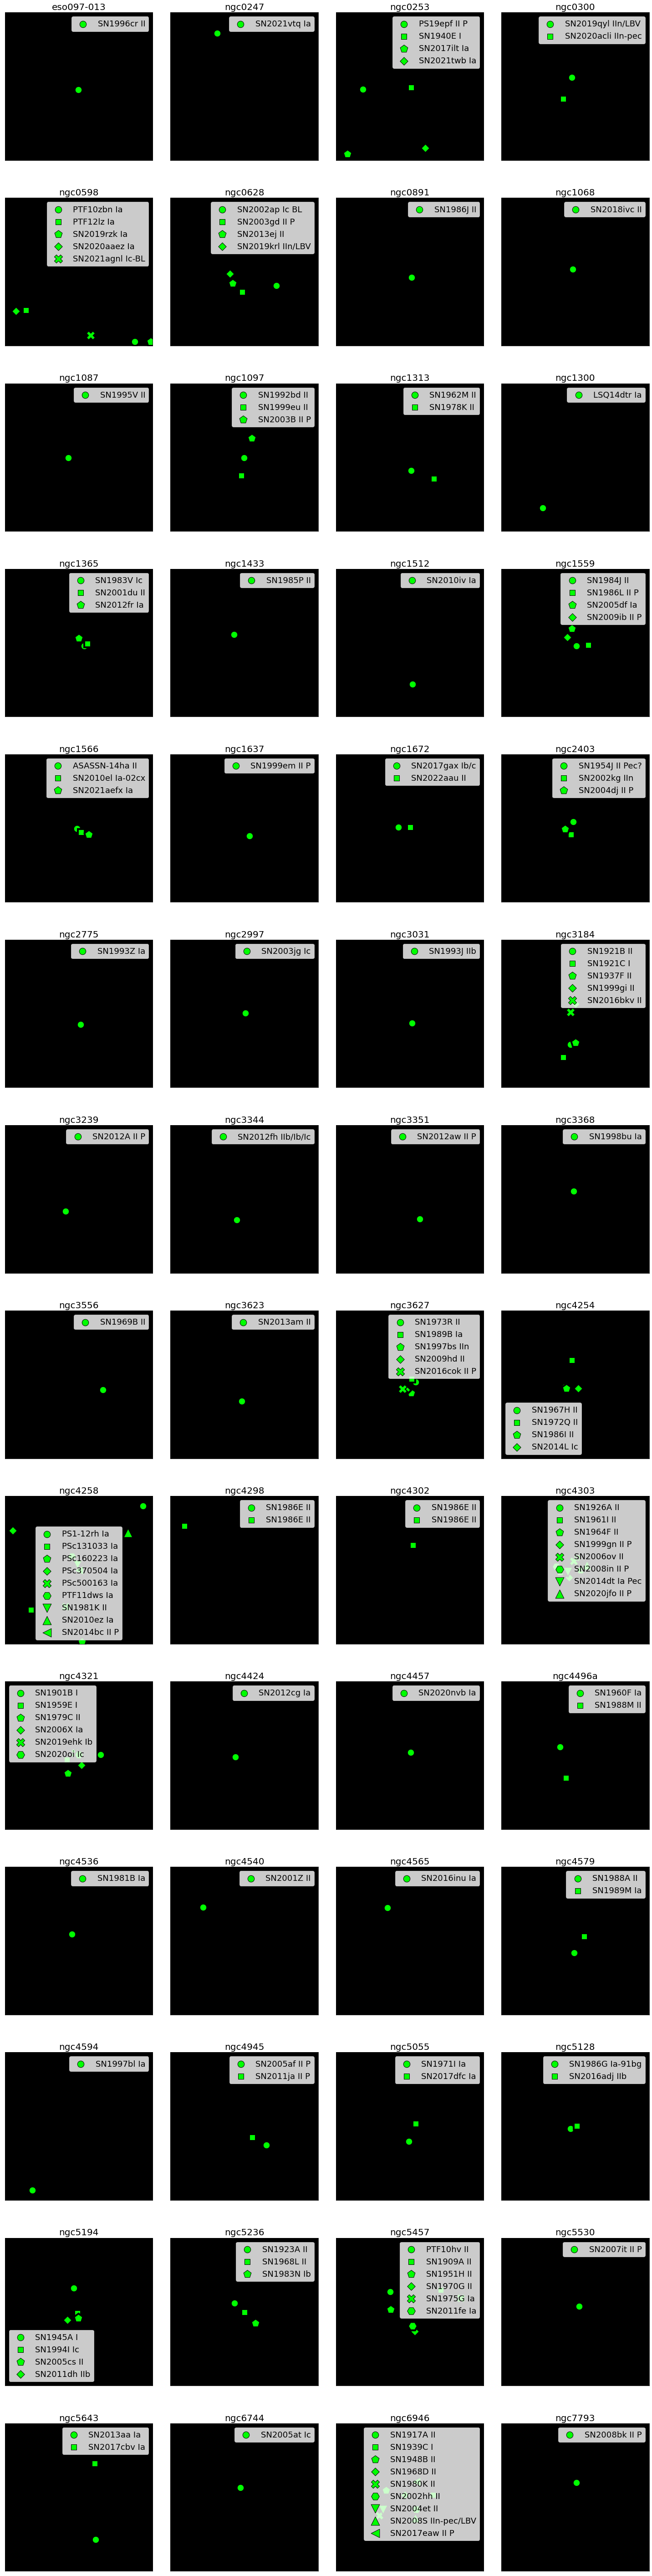

In [8]:
# make multipanel plot  

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 80))

for plot in plots:
    
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
#     if plot.size
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest")
    axs[i][j].set_title(gals[m], fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
      
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerEdges[n], 
                          zorder=2)
        
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n], zorder = 2)
    axs[i][j].legend(loc="best", fontsize=18)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1

plt.subplots_adjust(wspace=0.25, hspace=0.0)
plt.tight_layout()
plt.show()
fig.savefig("../Figures/AllPHANGSSNeGalaxies.pdf", dpi=300)
plt.close()
